In [1]:
import os
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout = go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

C:\Users\Lenovo\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('PGE_SA.csv').fillna('ffill')
df = df.sort_index(ascending=False)
df.index = range(len(df))
df['Data'] = pd.to_datetime(df['Data'])
df = df.rename(columns={'Maks.':'Maks'})
df = df.rename(columns={'Min.':'Min'})
df.head()

,Data,Otwarcie,Zamknięcie,Maks,Min,Obrót (mln. zł),Zmiana (%)
0,2010-10-01,17.16,16.98,17.16,16.85,30.36,0.00
1,2010-10-04,16.98,17.05,17.07,16.73,47.29,0.43
2,2010-10-05,16.99,16.82,17.00,16.82,36.29,-1.38
3,2010-10-06,16.87,16.50,16.93,16.50,48.64,-1.88
4,2010-10-07,15.72,15.84,16.05,15.67,271.00,-4.00


### Shift label column

In [3]:
for i in range(1, 31):
    name = 'Otwarcie_' + str(i) + 'day'
    df[name] = df['Otwarcie'].shift(-i)
    name = 'Zamknięcie_' + str(i) + 'day'
    df[name] = df['Zamknięcie'].shift(i)

### Drop invalid samples

In [4]:
df = df.iloc[31:]
df = df[:-30]
df.index = range(len(df))

### Split data

In [5]:
test_size = 0.2

test_split_idx = int(df.shape[0] * (1-test_size))

train_df = df.loc[:test_split_idx].copy()
test_df = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Data, y=train_df.Otwarcie, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Data, y=test_df.Otwarcie, name='Test'))
fig.show()

### Drop unnecessary columns

In [6]:
drop_cols = ['Data', 'Obrót (mln. zł)', 'Zmiana (%)', 'Otwarcie', 'Min', 'Maks']

train_df = train_df.drop(drop_cols, 1)
test_df = test_df.drop(drop_cols, 1)

## 1 day ahead

7 days of history data

In [7]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune XGBoostRegressor

In [8]:
parameters = {
    'n_estimators':[100, 200, 300, 400],
    'learning_rate':[0.001, 0.005, 0.01, 0.05],
    'max_depth':[8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state':[42]
}

tscv = TimeSeriesSplit(n_splits=3)
gsc = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)

{'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 300, 'random_state': 42}


In [9]:
model = xgb.XGBRegressor(**grid_result.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
y_pred = model.predict(X_test)

In [11]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 3.6485910488368645
MAE = 1.1370501415128629
RMSE = 1.9101285424904955


In [12]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_pred,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

30 days of history data

In [13]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)
X_train = train_df[x_label]
y_train = train_df['Otwarcie_1day']
X_test = test_df[x_label]
y_test = test_df['Otwarcie_1day']
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune XGBoostRegressor

In [14]:
parameters = {
    'n_estimators':[100, 200, 300, 400],
    'learning_rate':[0.001, 0.005, 0.01, 0.05],
    'max_depth':[8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state':[42]
}

tscv = TimeSeriesSplit(n_splits=3)
gsc = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=parameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)

{'gamma': 0.01, 'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 300, 'random_state': 42}


In [15]:
model = xgb.XGBRegressor(**grid_result.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
y_pred = model.predict(X_test)

In [17]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 3.6514887053437866
MAE = 1.1367851158855407
RMSE = 1.9108868897304692


In [18]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Otwarcie'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Data, y=df.Otwarcie,
                        name='Truth',
                        marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=predicted_prices.Otwarcie,
                        name='Prediction',
                        marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_test,
                        name='Truth',
                        marker_color='LightSkyBlue',
                        showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Data,
                        y=y_pred,
                        name='Prediction',
                        marker_color='MediumPurple',
                        showlegend=False), row=2, col=1)

fig.show()

## 7 days ahead

7 days of history data

In [19]:
x_label = ['Zamknięcie']
for i in range(1, 7):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label]
X_test = test_df[x_label]
y_test = test_df[y_label]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune XGBoostRegressor

In [20]:
model = MultiOutputRegressor(xgb.XGBRegressor())
hyperparameters = dict(estimator__learning_rate=[0.001, 0.005, 0.01, 0.05], 
                     estimator__n_estimators=[100, 200, 300, 400],
                     estimator__max_depth=[8, 10, 12, 15],
                     estimator__gamma=[0.001, 0.005, 0.01, 0.02],
                     estimator__random_state=[42])
tscv = TimeSeriesSplit(n_splits=3)
randomized_search = RandomizedSearchCV(model,
    hyperparameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print(hyperparameters_tuning.best_params_)

{'estimator__random_state': 42, 'estimator__n_estimators': 200, 'estimator__max_depth': 10, 'estimator__learning_rate': 0.05, 'estimator__gamma': 0.02}


In [21]:
print(hyperparameters_tuning.best_params_)

{'estimator__random_state': 42, 'estimator__n_estimators': 200, 'estimator__max_depth': 10, 'estimator__learning_rate': 0.05, 'estimator__gamma': 0.02}


In [22]:
model = hyperparameters_tuning.best_estimator_
y_pred = model.predict(X_test)

In [23]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 4.56661031018075
MAE = 1.431875470867002
RMSE = 2.1369628705667187


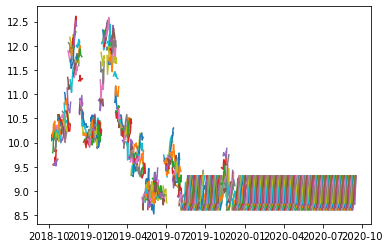

In [24]:
data = df.loc[test_split_idx+1:].Data
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)

30 days of history data

In [25]:
x_label = ['Zamknięcie']
for i in range(1, 30):
    label = 'Zamknięcie_'+ str(i) + 'day'
    x_label.append(label)

y_label = []
for i in range(1, 8):
    label = 'Otwarcie_'+ str(i) + 'day'
    y_label.append(label)
X_train = train_df[x_label]
y_train = train_df[y_label]
X_test = test_df[x_label]
y_test = test_df[y_label]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Fine-tune XGBoostRegressor

In [26]:
model = MultiOutputRegressor(xgb.XGBRegressor())
hyperparameters = dict(estimator__learning_rate=[0.001, 0.005, 0.01, 0.05], 
                     estimator__n_estimators=[100, 200, 300, 400],
                     estimator__max_depth=[8, 10, 12, 15],
                     estimator__gamma=[0.001, 0.005, 0.01, 0.02],
                     estimator__random_state=[42])
tscv = TimeSeriesSplit(n_splits=3)
randomized_search = RandomizedSearchCV(model,
    hyperparameters, cv=tscv, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1
)
hyperparameters_tuning = randomized_search.fit(X_train, y_train)
print(hyperparameters_tuning.best_params_)

{'estimator__random_state': 42, 'estimator__n_estimators': 400, 'estimator__max_depth': 15, 'estimator__learning_rate': 0.05, 'estimator__gamma': 0.02}


In [27]:
model = hyperparameters_tuning.best_estimator_
y_pred = model.predict(X_test)

In [28]:
print(f'MSE = {mean_squared_error(y_test, y_pred)}')
print(f'MAE = {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE = {math.sqrt(mean_squared_error(y_test, y_pred))}')

MSE = 4.849046073136156
MAE = 1.484835584631642
RMSE = 2.202054965966144


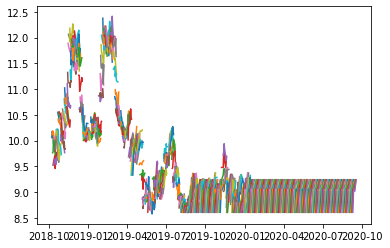

In [29]:
data = df.loc[test_split_idx+1:].Data
for i in range(len(y_pred)-7):
    x = data[i:i+7].tolist()
    y = y_pred[i]
    plt.plot(x, y)